In [10]:
import torch
import triton
import triton.language as tl

In [11]:
# https://github.com/pytorch/pytorch/issues/107960#issuecomment-1783432552
!export LC_ALL="en_US.UTF-8"
!export LD_LIBRARY_PATH="/usr/lib64-nvidia"
!export LIBRARY_PATH="/usr/local/cuda/lib64/stubs"
!ldconfig /usr/lib64-nvidia

/sbin/ldconfig.real: /usr/local/lib/libtbbbind_2_0.so.3 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbmalloc_proxy.so.2 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbmalloc.so.2 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbb.so.12 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbbind_2_5.so.3 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbbind.so.3 is not a symbolic link



Reference: https://www.youtube.com/playlist?list=PLSXcJOyFhmS-qb_CF-GLhkWxSmi-ftbPO

In [12]:
def naive_softmax(x: torch.Tensor) -> torch.Tensor:
  """Eager Mode Softmax"""
  x_max = x.max(dim = 1)[0]
  safe_x = x - x_max[:, None]
  numerator = torch.exp(safe_x)
  denominator = numerator.sum(dim=1)
  sum_out = numerator/denominator[:, None]
  return sum_out

In [13]:
@triton.jit
def _softmax_fwd_kernel(
    output_ptr,
    stride_output_row,
    input_ptr,
    stride_input_row,
    num_cols,
    block_size: tl.constexpr,
):
  # setup input ptrs
  row_index = tl.program_id(0)
  row_start_ptr = input_ptr + (row_index * stride_input_row)
  col_offsets = tl.arange(0,block_size)
  input_pointers = row_start_ptr + col_offsets

  row_mask = col_offsets < num_cols

  # move to SRAM
  row = tl.load(input_pointers, mask = row_mask, other = float("-inf"))

  # softmax itself
  safe_row = row - tl.max(row, axis=0)
  numerator = tl.exp(safe_row)
  denominator = tl.sum(numerator, axis=0)
  sm_out = numerator/denominator

  # write back to HBM
  output_row_ptr = output_ptr + (row_index * stride_output_row)
  output_pointers = output_row_ptr + col_offsets
  tl.store(output_pointers, sm_out, mask=row_mask)


def tl_softmax(x: torch.Tensor) -> torch.Tensor:
  """ Triton Softmax, Fwd Pass Only """
  rows, cols = x.shape
  assert x.dim() == 2, f"Accepts 2D Tensors Only"
  block_size = triton.next_power_of_2(cols)
  num_warps = 4
  if block_size > 2047:
    num_warps=8
  if block_size > 4095:
    num_warps=16
  grid = (rows,)

  # allocate our output buffer
  sm_out = torch.empty_like(x)
  _softmax_fwd_kernel[grid](
      sm_out,
      sm_out.stride(0),
      x,
      x.stride(0),
      cols,
      block_size=block_size,
      num_warps=num_warps
  )

  return sm_out


In [14]:
sample = torch.tensor([[1,2,3,4,5], [5,4,3,2,1]], dtype=torch.float32, device='cuda')

In [15]:
sample

tensor([[1., 2., 3., 4., 5.],
        [5., 4., 3., 2., 1.]], device='cuda:0')

In [16]:
ref_out = torch.softmax(sample, dim=1)
eager_out = naive_softmax(sample)
triton_out = tl_softmax(sample)

In [17]:
print("Ref Out = ", ref_out)
print("Eager Out = ", eager_out)
print("Triton Out = ", triton_out)

Ref Out =  tensor([[0.0117, 0.0317, 0.0861, 0.2341, 0.6364],
        [0.6364, 0.2341, 0.0861, 0.0317, 0.0117]], device='cuda:0')
Eager Out =  tensor([[0.0117, 0.0317, 0.0861, 0.2341, 0.6364],
        [0.6364, 0.2341, 0.0861, 0.0317, 0.0117]], device='cuda:0')
Triton Out =  tensor([[0.0117, 0.0317, 0.0861, 0.2341, 0.6364],
        [0.6364, 0.2341, 0.0861, 0.0317, 0.0117]], device='cuda:0')


## Benchmarking -

Source - https://triton-lang.org/main/getting-started/tutorials/02-fused-softmax.html#sphx-glr-getting-started-tutorials-02-fused-softmax-py

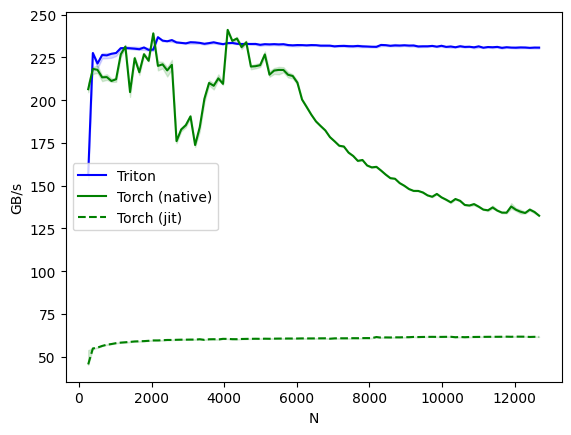

softmax-performance:
          N      Triton  Torch (native)  Torch (jit)
0     256.0  156.503885      206.412597    45.503212
1     384.0  227.555555      218.271443    54.834194
2     512.0  221.405396      217.727580    55.351349
3     640.0  226.376517      213.333326    56.302405
4     768.0  226.181195      213.472306    57.049837
..      ...         ...             ...          ...
93  12160.0  230.820452      134.758718    61.732619
94  12288.0  230.760556      134.020450    61.720878
95  12416.0  230.578527      136.019166    61.566097
96  12544.0  230.735690      134.623031    61.641276
97  12672.0  230.703120      132.455423    61.574258

[98 rows x 4 columns]


In [19]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N'],  # argument names to use as an x-axis for the plot
        x_vals=[128 * i for i in range(2, 100)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=[
            'triton',
            'torch-native',
            'torch-jit',
        ],  # possible values for `line_arg``
        line_names=[
            "Triton",
            "Torch (native)",
            "Torch (jit)",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('green', '--')],  # line styles
        ylabel="GB/s",  # label name for the y-axis
        plot_name="softmax-performance",  # name for the plot. Used also as a file name for saving the plot.
        args={'M': 4096},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(M, N, provider):
    x = torch.randn(M, N, device='cuda', dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'torch-native':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.softmax(x, axis=-1), quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: tl_softmax(x), quantiles=quantiles)
    if provider == 'torch-jit':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: naive_softmax(x), quantiles=quantiles)
    gbps = lambda ms: 2 * x.nelement() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms), gbps(max_ms), gbps(min_ms)


benchmark.run(show_plots=True, print_data=True)